# Basics

This tutorial covers the basics of working with nix files.

1. Opening and closing nix files with different file ``FileModes``.
2. Storing data and using dimension descriptors.

## Working with Files

In [1]:
import nixio
print("nixio library version:", nixio.__version__)

nixio library version: 1.5.1


### create a new file

* The following command tries to open the file "new_data_file.nix" in ``nix.FileMode.ReadWrite`` mode.
* If it does not exist, it will be created.

In [2]:
nixfile = nixio.File.open("new_data_file.nix", nixio.FileMode.ReadWrite)
print("file format:", nixfile.format)
print("nix data model version:", nixfile.version)

file format: nix
nix data model version: (1, 2, 1)


### nixio writes hdf5 files

* The file is an HDF5 file, the standard file extension would be ``*.h5``
* The file extension can be anything you wish.
* We will always use ``*.nix`` to indicate how it should be opened.

Files can be opened in different ``FileModes``, nixio defines three different modes:

1. ``nixio.FileMode.ReadWrite`` the default mode
2. ``nixio.FileMode.ReadOnly``
3. ``nixio.FileMode.Overwrite``

An opened file should be closed after you are done with it to finish any pending write and free any resources used by h5py.

In [3]:
nixfile.close()

The written file is an [HDF5](https://www.hdfgroup.org/) file, we can use the tools that are provided by the HDF5 library to access the file.

In [5]:
!h5ls -v new_data_file.nix

Opened "new_data_file.nix" with sec2 driver.
data                     Group
    Location:  1:432
    Links:     1
metadata                 Group
    Location:  1:672
    Links:     1


In [6]:
print("#" * 10, "Opening a file in ReadOnly mode", "#" * 10)

nixfile = nixio.File.open("new_data_file.nix", nixio.FileMode.ReadOnly)
print("Adding a Block to the file will fail ...")
try:
    nixfile.create_block("new block", "nix.session")
except:
    print("File mode", nixfile.mode, "(reading)")
    print("creating the block failed! The file is opened in ReadOnly mode")
nixfile.close()

########## Opening a file in ReadOnly mode ##########
Adding a Block to the file will fail ...
File mode r (reading)
creating the block failed! The file is opened in ReadOnly mode


In [7]:
print("#" * 10, "Opening a file in ReadWrite mode", "#" * 10)

nixfile = nixio.File.open("new_data_file.nix", nixio.FileMode.ReadWrite)
print("File mode", nixfile.mode, "(append)")
nixfile.create_block("new block", "nix.session")
print("Blocks in file", nixfile.blocks)
nixfile.close()

########## Opening a file in ReadWrite mode ##########
File mode a (append)
Blocks in file [Block: {name = new block, type = nix.session}]


In [8]:
print("#" * 10, "Opening a file in Overwrite mode", "#" * 10)

nixfile = nixio.File.open("new_data_file.nix", nixio.FileMode.Overwrite)
print("File mode", nixfile.mode, "(write)")
print("All formerly stored information is gone when using Overwrite")
print("Blocks in file", nixfile.blocks)
nixfile.close()

########## Opening a file in Overwrite mode ##########
File mode w (write)
All formerly stored information is gone when using Overwrite
Blocks in file []


## Unique IDs & Timestamps

Upon creation some standard fields are created on almost any nix-entity

1. ID
2. created_at
3. updated_at


### ID

The ID field is a text field automatically created and filled with a string randomly generated from the 36 characters drawn from Base32hex alphabet (RFC 4648)

The ID has an extreme low collision probability and can be used as a unique identifier.

### created_at, updated_at

Both are automatically set when an entity is created.
`updated_at` is only updated when the information of the entity itself is changed. If one wants to change this timestamp, one can use the `force_updated_at` method.

In [9]:
import time
import datetime as dt
nixfile = nixio.File.open("new_data_file.nix", nixio.FileMode.Overwrite)
print("id:", nixfile.id)
print("created at:", dt.datetime.fromtimestamp(nixfile.created_at))
print("updated at:", dt.datetime.fromtimestamp(nixfile.updated_at))

time.sleep(2)
block = nixfile.create_block("test block", "nix.session")
nixfile.force_updated_at()
print("created at:", dt.datetime.fromtimestamp(nixfile.created_at))
print("updated at:", dt.datetime.fromtimestamp(nixfile.updated_at))

print("block created at:", dt.datetime.fromtimestamp(block.created_at))
print("block updated at:", dt.datetime.fromtimestamp(block.updated_at))

time.sleep(2)
block.definition = "The recording sesssion"
print("block created at:", dt.datetime.fromtimestamp(block.created_at))
print("block updated at:", dt.datetime.fromtimestamp(block.updated_at))

nixfile.close()

id: 5340ec66-a004-4a3c-bece-786807bdb40f
created at: 2021-08-30 15:30:46
updated at: 2021-08-30 15:30:46
created at: 2021-08-30 15:30:46
updated at: 2021-08-30 15:30:48
block created at: 2021-08-30 15:30:48
block updated at: 2021-08-30 15:30:48
block created at: 2021-08-30 15:30:48
block updated at: 2021-08-30 15:30:50


# Storing data in a NIX file

Main purpose of a nix-file is to store data.

E.g. when recording the membrane or field potential data... 
Usually, these data are read as floats representing the potential and are sampled at evenly spaced times at a given *sampling rate*.

![data model](resources/nix_regular_sampled.png)

We need to store:
- the data (voltage measurements)
- the y-axis labeling, i.e. label (voltage) and unit (mV)
- the x-axis labeling, i.e. label (time) and unit (s)
- the x-position for each data point
- a title/legend


## The DataArray

**DataArrays** store the data. They live inside a **Block** entity that is a top-level grouping element.

But, it only stores the y-values!

The x-positions are defined by a **Dimension** descriptor. In this case this descriptor stores:

- a definition of the x-axis consisting of an offset
- the sampling interval
- a label
- and a unit.


In [10]:
import numpy as np

dt = 0.001
duration = 10.0
time = np.arange(0.0, duration, dt)
voltage_data = np.sin(2 * np.pi * time * 0.5)

nixfile = nixio.File.open("regularly_sampled_data.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("session 1", "nix.session")
array = block.create_data_array("sinewave", "nix.data.sampled", data=voltage_data, label="voltage", unit="Hz")
array.append_sampled_dimension(dt, label="time", unit="s")

nixfile.close()


## Reading Data from a DataArray

Storing is one thing, reading out the information is the obvious next step...


In [11]:
nixfile = nixio.File.open("regularly_sampled_data.nix", nixio.FileMode.ReadOnly)
block = nixfile.blocks[0]
array = block.data_arrays["sinewave"]
print(array)


DataArray: {name = sinewave, type = nix.data.sampled}


Cool, now we found the **DataArray** that contains the data. What to do with it? Let's find out some of it's properties.

In [12]:
print("Name, id, and type", array.name, array.id, array.type)
print("Data extent (aka shape), and data type:", array.data_extent, array.dtype)
print("Label and unit of the data:", array.label, array.unit)
import sys
print("DataArray size in memory:", sys.getsizeof(array), "bytes")

Name, id, and type sinewave 644e667d-36f5-41cf-9d06-a7b67a2fe6a0 nix.data.sampled
Data extent (aka shape), and data type: (10000,) float64
Label and unit of the data: voltage Hz
DataArray size in memory: 48 bytes


the *array* object we read from file is small. It can not possibly contain 10000 double values and all the other information...

**Note:** nixio objects are lightweight objects that are basically pointers to the location in the file!
Every time we read information from it, it is a read access to the file. This makes them cheap to create and maintain in memory but reading information takes a little.

--> So, how to read the data itself? We need to access it and can use numpy style to do so.

In [13]:

sinewave_data = array[:]
print(type(sinewave_data), sinewave_data.shape)

partial_sinewave_data = array[::10]
print(type(partial_sinewave_data), partial_sinewave_data.shape)

<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (1000,)


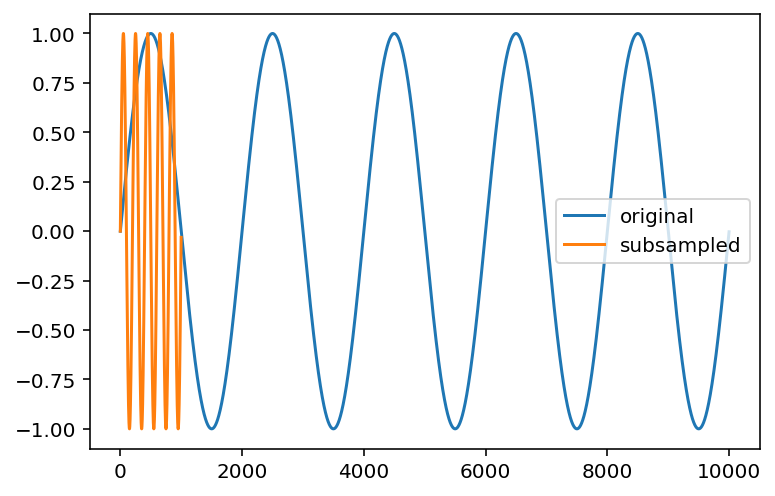

In [14]:

%config InlineBackend.figure_formats = ['retina'] # only for users with a high resolution display
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sinewave_data, label="original")
plt.plot(partial_sinewave_data, label="subsampled")
plt.legend()





It is a plot but some parts are missing...

All this information is stored in the **DataArray**.

Let's start with the y-labeling: This information is stored in the **DataArray** itself.


Text(0, 0.5, 'voltage [Hz]')

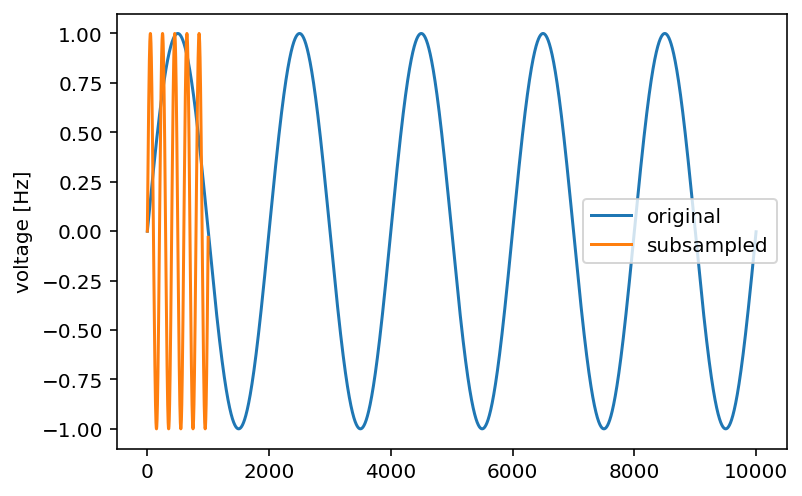

In [15]:
plt.plot(sinewave_data, label="original")
plt.plot(partial_sinewave_data, label="subsampled")
plt.legend()
plt.ylabel("%s [%s]" % (array.label, array.unit))

What about the x-labeling? To fix this we need to get the dimension descriptor for the time-dimension.

Text(0.5, 0, 'time [s]')

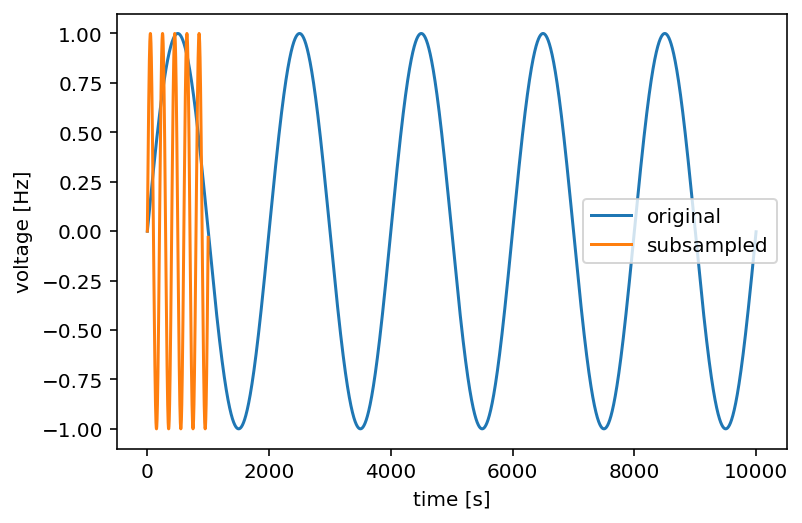

In [16]:
time_dimension = array.dimensions[0]

plt.plot(sinewave_data, label="original")
plt.plot(partial_sinewave_data, label="subsampled")
plt.legend()
plt.ylabel("%s [%s]" % (array.label, array.unit))
plt.xlabel("%s [%s]" % (time_dimension.label, time_dimension.unit))

So far so good. But something's still off, let's fix this:

We need to use further information from the dimension descriptor (the sampling interval, and the offset) to create it with numpy, or we ask the dimension descriptor to do it for us.

Text(0.5, 0, 'time [s]')

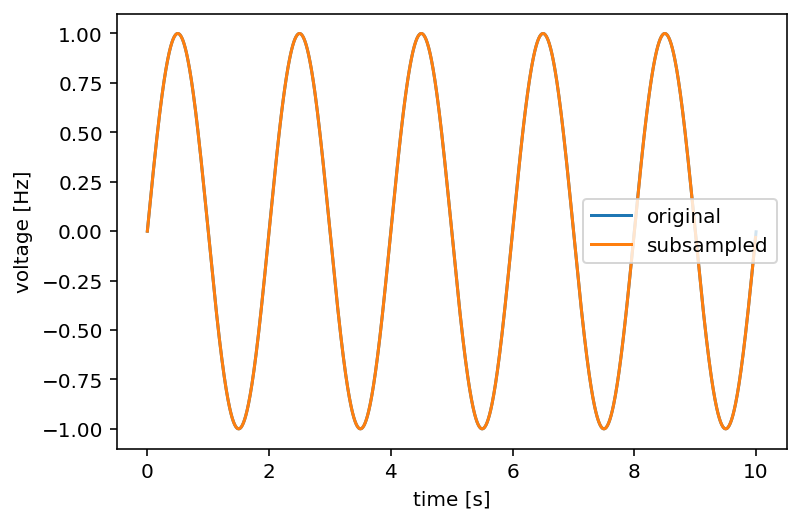

In [17]:

time_dimension = array.dimensions[0]
sinewave_time_axis = time_dimension.axis(len(sinewave_data))
partial_sinewave_time_axis = sinewave_time_axis[::10]

plt.plot(sinewave_time_axis, sinewave_data, label="original")
plt.plot(partial_sinewave_time_axis, partial_sinewave_data, label="subsampled")
plt.legend()
plt.ylabel("%s [%s]" % (array.label, array.unit))
plt.xlabel("%s [%s]" % (time_dimension.label, time_dimension.unit))

**Done!**

## Irregularly sampled data

What about data that is not regularly sampled (in time)?

![data model](resources/nix_irregular_sampled.png)

A signal similar to what we had before is recorded but this time the temporal distance between the measurements is not regular. Storing this kind of data is not as efficient as in the regularly sampled case since we need to store the time of each measurement and the measured value. The following information needs to be stored to describe the dimension:

1. x-positions of the data points, i.e. ticks
2. label
3. unit

In this kind of dimension we store a range of ticks, therefore the name **RangeDimension**. It needs to be added to the **DataArray** when it is created.

### Radar trap example scenario

Let's consider a scenario in which information does not flow in in a steady stream but comes in irregularly such as a radar trap. With each passing car there will be a measurement but the intervals at which the measurements are taken are defined by the traffic, not the measurement system.


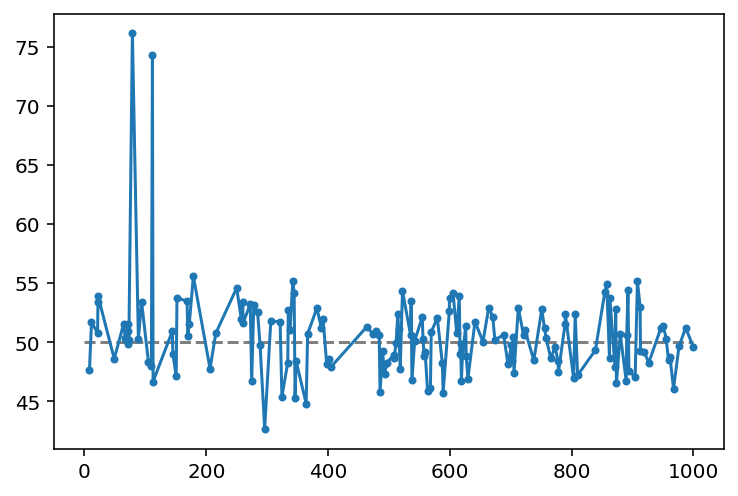

In [18]:
import numpy as np

def radar_trap_data(duration=1000, car_probability=0.15, dt=0.01, speed_limit=50, speeder_probability=0.01):
    time = np.arange(0, duration, dt)
    car_times = time[np.random.random(len(time)) < (car_probability * dt)]
    car_speeds = speed_limit + np.random.randn(len(car_times)) * 0.05 * speed_limit
    indices = np.arange(len(car_times), dtype=int)
    np.random.shuffle(indices)
    speeders = indices[:int(np.round(speeder_probability * len(car_times)))]
    car_speeds[speeders] += 0.5 * speed_limit
    return car_times, car_speeds


times, speeds = radar_trap_data()

plt.plot(times, speeds, marker=".", zorder=2)
plt.hlines([50], 0, times[-1], color="grey", ls="--", zorder=1)

In [19]:
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("radar trap", "speed measurements")

data_array = block.create_data_array("car speeds", "nix.irregular_sampled", data=speeds, label="speed", unit="km/h")
data_array.append_range_dimension(ticks=times, unit="s", label="time")

nixfile.close()

### Spike times

Sometimes the times of certain events (e.g. action potentials in neurophysiology) is the the data and the dimension at the same time.

Since the data is still irregularly sampled, we use a **RangeDimension** to describe the time axis but we tell it to use the "parent" **DataArray** as a source for the ticks.

```
spike_times = get_spike_times(data)

spikes_data_array = block.create_data_array("spike times", "nix.irregular_sampled.spike_times", data=spike_times, label="time", unit="s")
spikes_data_array.append_range_dimension_using_self()
```

## Categorical data

![data model](resources/nix_set_dimension.png)

If we need to store data that falls into categories, i.e. the x-positions are not numeric or the dimension does not have a natural order, a SetDimension is used. It stores a label for each entry along the described dimension.

In [20]:
def create_data():
    categories = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]
    temperatures = [100, 110, 95, 150, 200, 250]

    return temperatures, categories

temperatures, months = create_data()

nixfile = nixio.File.open("categorical_data.nix", nixio.FileMode.Overwrite)

block = nixfile.create_block("weather data", "test")
data_array = block.create_data_array("category data", "nix.categorical", data=temperatures, label="temperature", unit="K")
data_array.append_set_dimension(labels=months)

nixfile.close()

## 2-D data

**DataArrays** can store n-dimensional data. In such cases we need to provide n dimension descriptors.

![data model](resources/multiple_channels.png)

The first dimension represents time, the second the channels. Since the data is regularly sampled the time dimension is fully described by a **SampledDimension**, the channel dimension is described by a **SetDimension** which contains the channel names.

In [21]:
def create_data(duration=10, num_channels=10, dt=0.0001):
    samples = int(duration / dt)
    data = np.zeros((samples, num_channels))
    time = np.arange(samples) * dt
    for i in range(num_channels):
        phase = i * 2 * np.pi / num_channels
        data[:, i] = np.sin(2 * np.pi * time + phase) + (np.random.randn(samples) * 0.1)

    return data


dt = 0.001
duration = 10
number_of_channels = 10
multichannel_data = create_data(duration, number_of_channels, dt)

nixfile = nixio.File.open("multichannel_data.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("Session 1", "nix.recording_session")

data_array = block.create_data_array("multichannel_data", "nix.sampled.multichannel", data=multichannel_data, label="voltage", unit="mV")
data_array.append_sampled_dimension(0.001, label="time", unit="s")
data_array.append_set_dimension(labels=["channel %i" % i for i in range(number_of_channels)])

nixfile.close()

## It's time for a short break and some exercises.

In the folder "day_1" of the repository https://gin.g-node.org/INCF-workshop-2021/NIX-Neo-workshop you will find a Jupyter notebook "hands_on_1.ipynb".

Again, start it either

- locally if you can use Python and make sure all dependencies are installed.
- or use Binder if you cannot use Python locally. The repository is already set up for the use with Binder.
